# Decision Dependent Games Simulation
## Uber vs. Lyft

We introduce fictional performative effects on top of real data scraped from Uber and Lyft to simulate a decision dependent risk minimization game.

In [1]:
import math
import numpy as np
import pandas as pd
import sys
import datetime

sys.path.append("../utils/")
from utils_rideshare import *

from dd_game_rideshare import *
from two_stage_player_rideshare import *
from dfo_player_rideshare import *

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
sns.set_style('darkgrid')

from tqdm import tqdm, trange
tqdm.pandas()

C:\Users\evanj\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
rides = pd.read_csv('../data/rideshare_kaggle.csv')
rides['date'] = rides.progress_apply(lambda row: datetime.datetime.strptime(row['datetime'], '%Y-%m-%d %H:%M:%S').date(), axis=1)

new_rides = rides[['hour','cab_type','price','distance','date']].dropna(subset = ['price']).reset_index()
new_rides['distance'] = new_rides.progress_apply(lambda row: math.ceil(row['distance']), axis=1)
new_rides['price'] = new_rides.progress_apply(lambda row: 5*math.floor(row['price']/5), axis=1)

cab_types_ = new_rides.cab_type.unique()
distances_ = new_rides.distance.unique()
hours_ = np.array([17,18,19])  # new_rides.hour.unique()
prices_ = np.array([5*(i+1) for i in range(10)])  # new_rides.price.unique()
dates = len(new_rides.date.unique())

g = np.zeros((len(cab_types_),len(prices_),len(hours_),len(distances_)))

for i in range(len(cab_types_)):
    for j in trange(len(prices_)):
        for k in range(len(hours_)):
            for m in range(len(distances_)):
                g[i,j,k,m] = len(new_rides[(new_rides['cab_type']==cab_types_[i])
                                          &(new_rides['price']==prices_[j])
                                          &(new_rides['hour']==hours_[k])
                                          &(new_rides['distance']==distances_[m])])/dates

np.random.seed(10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.16it/s]


# Configurations

In [3]:
x = [10,17,2]  # [price, time, distance]
g_uber = g[np.where(cab_types_=='Uber'),np.where(prices_==x[0]),np.where(hours_==x[1]),np.where(distances_==x[2])]
g_lyft = g[np.where(cab_types_=='Lyft'),np.where(prices_==x[0]),np.where(hours_==x[1]),np.where(distances_==x[2])]

print(f'g_uber = {g_uber}')
print(f'g_lyft = {g_lyft}')

d_1 = len(g_uber)  # Dimension of each player's data/strategy
d_2 = len(g_lyft)

lambda_p1 = 1e-3
lambda_p2 = 1e-3

eta_p1 = 1e-3
eta_p2 = 1e-3

mu_p1 = np.array([-10])
gamma_p1 = np.array([5])
mu_p2 = np.array([-10])
gamma_p2 = np.array([5])

g_uber = [[52.11764706]]
g_lyft = [[76.64705882]]


In [4]:
p1_data_params = (g_uber, d_1, mu_p1, gamma_p1, lambda_p1, eta_p1)
p1_data_generating_func = sample_from_location_family_rideshare

p2_data_params = (g_lyft, d_2, mu_p2, gamma_p2, lambda_p2, eta_p2)
p2_data_generating_func = sample_from_location_family_rideshare

In [5]:
num_rounds_lst = np.logspace(2,5,20,dtype='int')
num_test = 1

# Run game with 2-stage algorithm

In [6]:
p1_risks = []
p2_risks = []
theta_final_p1 = []
theta_final_p2 = []

for num_rounds in num_rounds_lst:
    num_alternate_rounds = num_rounds
    print(f"num_rounds = {num_rounds}")
    player_one = TwoStagePlayer()
    player_two = TwoStagePlayer()
    game_ts = DecisionDependentGame(player_one, player_two,
                                    p1_data_params, p2_data_params,
                                    p1_data_generating_func, p2_data_generating_func,
                                    num_rounds, num_alternate_rounds, num_test)
    
    game_ts.run_train()
    game_ts.run_post_train_alternating()
    
    PR1 = game_ts.evaluate_perf_risk_p1()
    PR2 = game_ts.evaluate_perf_risk_p2()
    
    p1_risks.append(PR1)
    p2_risks.append(PR2)
    
    theta_final_p1.append(game_ts.theta_p1)
    theta_final_p2.append(game_ts.theta_p2)
    
    #Change this flag if one wants to change print settings
    if True:
        print("---------------------")
        print("Player 1: Actual mu, gamma")
        print(mu_p1.T, gamma_p1.T)
        print("Player 1: Estimated mu, gamma")
        print(player_one.mu_hat.T, player_one.gamma_hat.T)
        print("Player 1 Risk:")
        print(PR1)

        print("Player 2: Actual mu, gamma")
        print(mu_p2.T, gamma_p2.T)
        print("Player 2: Estimated mu, gamma")
        print(player_two.mu_hat.T, player_two.gamma_hat.T)
        print("Player 2 Risk:")
        print(PR2)
        print("---------------------")

num_rounds = 100
---------------------
Player 1: Actual mu, gamma
[-10] [5]
Player 1: Estimated mu, gamma
[-8.45106323] [-0.47099711]
Player 1 Risk:
[[-382.37254845]]
Player 2: Actual mu, gamma
[-10] [5]
Player 2: Estimated mu, gamma
[-18.01453286] [8.05165011]
Player 2 Risk:
[[-720.56212406]]
---------------------
num_rounds = 143
---------------------
Player 1: Actual mu, gamma
[-10] [5]
Player 1: Estimated mu, gamma
[-27.60215246] [-2.78617479]
Player 1 Risk:
[[-498.34881998]]
Player 2: Actual mu, gamma
[-10] [5]
Player 2: Estimated mu, gamma
[-23.33524996] [-20.01781282]
Player 2 Risk:
[[-587.82868871]]
---------------------
num_rounds = 206
---------------------
Player 1: Actual mu, gamma
[-10] [5]
Player 1: Estimated mu, gamma
[-9.57718598] [3.49122863]
Player 1 Risk:
[[-609.98482949]]
Player 2: Actual mu, gamma
[-10] [5]
Player 2: Estimated mu, gamma
[-14.20804334] [6.99093411]
Player 2 Risk:
[[-680.63559323]]
---------------------
num_rounds = 297
---------------------
Player 1

# Run game with DFO players

In [7]:
p3_risks = []
p4_risks = []
theta_final_p3 = []
theta_final_p4 = []

delta = 1
eta = 1e-4
num_test = 5
num_rounds = num_rounds_lst[-1]

player_three = DFOPlayer(delta,eta)
player_four = DFOPlayer(delta,eta)
game_dfo = DecisionDependentGame(player_three, player_four,
                                 p1_data_params, p2_data_params,
                                 p1_data_generating_func, p2_data_generating_func,
                                 num_test)

for i in trange(num_rounds+1):
    game_dfo.theta_p1 = player_three.perturb_theta()
    game_dfo.theta_p2 = player_four.perturb_theta()
    
    PR_3_oracle = game_dfo.evaluate_perf_risk_p1()
    PR_4_oracle = game_dfo.evaluate_perf_risk_p2()
    
    game_dfo.theta_p1 = player_three.update_theta(PR_3_oracle)
    game_dfo.theta_p2 = player_four.update_theta(PR_4_oracle)
    
    if i in num_rounds_lst:
        p3_risks.append(PR_3_oracle)
        p4_risks.append(PR_4_oracle)
        
        theta_final_p3.append(game_dfo.theta_p1)
        theta_final_p4.append(game_dfo.theta_p2)
    
        if False:
            print("---------------------")
            print(f"Iteration {i}")
            print("Player 3 risk:")
            print(PR_3_oracle)

            print("Player 4 risk:")
            print(PR_4_oracle)
            print("---------------------")
            
print(np.mean(game_dfo.p1.theta_history))
print(np.mean(game_dfo.p2.theta_history))
theta_final_p3[-1] = np.mean(game_dfo.p1.theta_history)
theta_final_p4[-1] = np.mean(game_dfo.p2.theta_history)

100%|████████████████████████████████████████████████████████████████████████| 100001/100001 [1:49:03<00:00, 15.28it/s]
C:\Users\evanj\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


-2.1573278421259516
-1.2956886351871582


## Plots

C:\Users\evanj\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\evanj\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


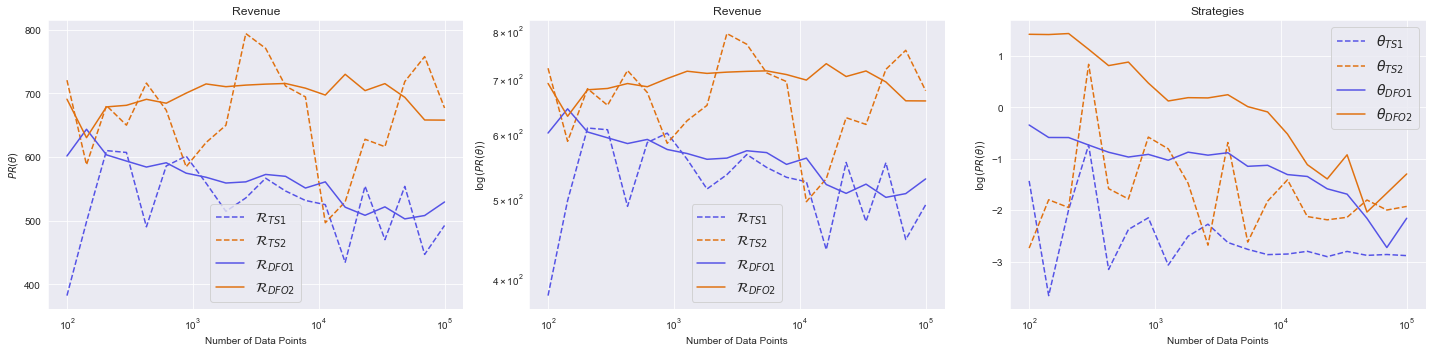

In [8]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.semilogx(num_rounds_lst, -np.squeeze(p1_risks),
             '--', color='#5553E6', label=r'$\mathcal{R}_{TS1}$')
plt.semilogx(num_rounds_lst, -np.squeeze(p2_risks),
             '--', color='#E07110', label=r'$\mathcal{R}_{TS2}$')

plt.semilogx(num_rounds_lst, -np.squeeze(p3_risks),
             '-', color='#5553E6', label=r'$\mathcal{R}_{DFO1}$')
plt.semilogx(num_rounds_lst, -np.squeeze(p4_risks),
             '-', color='#E07110', label=r'$\mathcal{R}_{DFO2}$')

plt.xlabel("Number of Data Points")
plt.ylabel(r"$PR(\theta)$")
plt.title("Revenue")
plt.legend(fontsize=14)

plt.subplot(1,3,2)
plt.loglog(num_rounds_lst, -np.squeeze(p1_risks),
           '--', color='#5553E6', label=r'$\mathcal{R}_{TS1}$')
plt.loglog(num_rounds_lst, -np.squeeze(p2_risks),
           '--', color='#E07110', label=r'$\mathcal{R}_{TS2}$')

plt.loglog(num_rounds_lst, -np.squeeze(p3_risks),
           '-', color='#5553E6', label=r'$\mathcal{R}_{DFO1}$')
plt.loglog(num_rounds_lst, -np.squeeze(p4_risks),
           '-', color='#E07110', label=r'$\mathcal{R}_{DFO2}$')

plt.xlabel("Number of Data Points")
plt.ylabel(r"$\log(PR(\theta))$")
plt.title('Revenue')
plt.legend(fontsize=14)

plt.subplot(1,3,3)
plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p1),
           '--', color='#5553E6', label=r'$\theta_{TS1}$')
plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p2),
           '--', color='#E07110', label=r'$\theta_{TS2}$')

plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p3),
           '-', color='#5553E6', label=r'$\theta_{DFO1}$')
plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p4),
           '-', color='#E07110', label=r'$\theta_{DFO2}$')

# plt.ylim(-10,10)
plt.xlabel("Number of Data Points")
plt.ylabel(r"$\log(PR(\theta))$")
plt.title('Strategies')
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('DD_regression_rideshare_convergence.jpg', format='jpg')
plt.show()

C:\Users\evanj\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


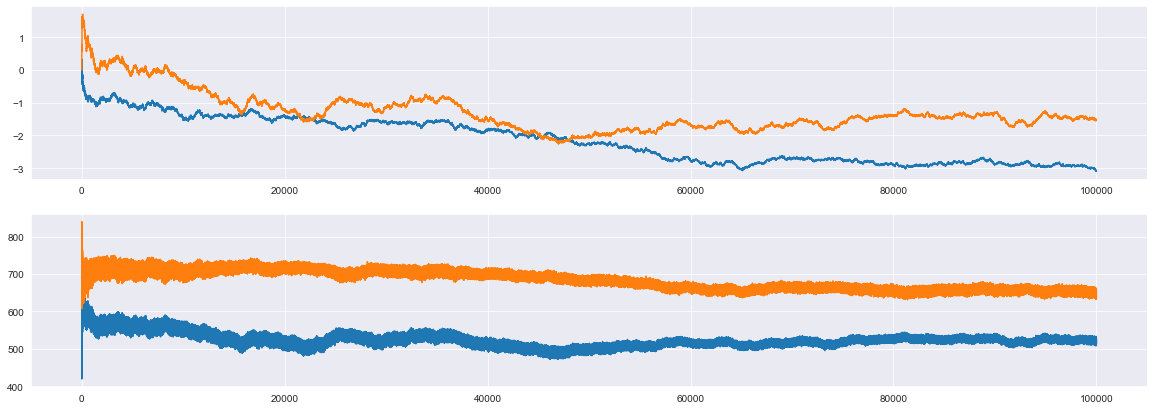

In [9]:
plt.figure(figsize=(20,7))
plt.subplot(2,1,1)
plt.plot(game_dfo.p1.theta_history)
plt.plot(game_dfo.p2.theta_history)
plt.subplot(2,1,2)
plt.plot(-np.squeeze(game_dfo.p1.risk_history))
plt.plot(-np.squeeze(game_dfo.p2.risk_history))
plt.show()

In [10]:
print(game_ts.theta_p1)
print(game_ts.theta_p2)
print(game_dfo.theta_p1)
print(game_dfo.theta_p2)

[-2.88426668]
[-1.92712039]
[[-3.09322134]]
[[-1.51159399]]
